# 多重スリットにおける回折・干渉実験の光の強度分布(3次元版)

### 必要なライブラリのインポート

In [ ]:
#!pip install numba

In [2]:
#%matplotlib notebook
import numpy as np
import itertools
import numba
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import LinearLocator

### 各種設定

In [3]:
# スリットースクリーン間距離
L = 1.0*10**2
# 光の波長
lam = 0.1*10**(-7)
# スクリーンの初期位置
x_0 = 10.0
# 波数
k = (2*np.pi)/lam

![回折](回折.jpg) 

### numpy.meshgrid()を利用するための格子点の設定

In [4]:
# 格子の分割数
m = 2**8 + 1
# スクリーンのx,y座標の設定
X,Y = np.meshgrid(np.linspace(-x_0, x_0, m), np.linspace(-x_0, x_0, m))
# 強度分布格納用配列の初期化
I_points = np.zeros([m, m])

### 回転角の設定

In [5]:
# 回転角の設定
p_x = 0
p_y = 0
p_z = 0
Theta = np.array([p_x, p_y, p_z])

### 座標を回転させる関数の定義

In [6]:
def Rotation(Theta, df):
    # 回転行列
    theta_x = Theta[0]
    theta_y = Theta[1]
    theta_z = Theta[2]
    rotation_z = np.array([[np.cos(theta_z), np.sin(theta_z), 0],
                           [-np.sin(theta_z), np.cos(theta_z), 0],
                           [0, 0, 1]])
    rotation_y = np.array([[np.cos(theta_y), 0, -np.sin(theta_y)],
                           [0, 1, 0],
                           [np.sin(theta_y), 0, np.cos(theta_y)]])
    rotation_x = np.array([[1, 0, 0],
                           [0, np.cos(theta_x), np.sin(theta_x)],
                           [0, -np.sin(theta_x), np.cos(theta_x)]])
    Rotation_matrix = rotation_z@rotation_y@rotation_x
    
    arr_data = df.values
    # 行列積の計算
    new_data = Rotation_matrix@arr_data.T
    return new_data

### 単位格子の座標のデータフレームの作成

In [7]:
# x軸方向のスリット間距離
dx = 0.1
# y軸方向のスリット幅
dy = 0.1
# y軸方向のスリット幅
dz = 0.1
# スリット数(奇数限定)
N = 5
n = (N-1)*0.5
# スリット番号の配列
slit_number = np.arange(-n, n+1)

In [8]:
# 係数の設定
slit_coordinate_array = np.array(list(itertools.product(np.arange(-N, N+1), repeat=3)))
slit_coordinate_array

array([[-5, -5, -5],
       [-5, -5, -4],
       [-5, -5, -3],
       ...,
       [ 5,  5,  3],
       [ 5,  5,  4],
       [ 5,  5,  5]])

In [9]:
"""
new_slit_number = []
i = 0
while(i<=1):
    for j in range(len(slit_number)):
        new_slit_number.append(slit_number[j])
    i += 1
new_slit_number = np.array(new_slit_number)
z_number = 0.5*np.ones(N)
new_z_number = np.append(z_number, [-z_number])
"""
df_slit_data = pd.DataFrame(
    data = {'x': dx*slit_coordinate_array[:, 0], #x座標の指定
            'y': dy*slit_coordinate_array[:, 1], # y座標の指定
            'z': dz*slit_coordinate_array[:, 2]}
)

In [10]:
# 作成したデータフレームの確認
df_slit_data

,x,y,z
0,-0.5,-0.5,-0.5
1,-0.5,-0.5,-0.4
2,-0.5,-0.5,-0.3
3,-0.5,-0.5,-0.2
4,-0.5,-0.5,-0.1
...,...,...,...
1326,0.5,0.5,0.1
1327,0.5,0.5,0.2
1328,0.5,0.5,0.3
1329,0.5,0.5,0.4


In [11]:
#df_slit_data.drop(df_slit_data.index[[3, 4, 5]], inplace=True)

In [12]:
# 作成したデータフレームの確認
df_slit_data.values

array([[-0.5, -0.5, -0.5],
       [-0.5, -0.5, -0.4],
       [-0.5, -0.5, -0.3],
       ...,
       [ 0.5,  0.5,  0.3],
       [ 0.5,  0.5,  0.4],
       [ 0.5,  0.5,  0.5]])

In [13]:
# 単位行列の生成
e_matrix = np.eye(3)
# 係数の設定
c_0 = 1
coefficient_array = np.array(list(itertools.product(np.arange(-c_0, c_0+1), repeat=3)))
coefficient_array

array([[-1, -1, -1],
       [-1, -1,  0],
       [-1, -1,  1],
       [-1,  0, -1],
       [-1,  0,  0],
       [-1,  0,  1],
       [-1,  1, -1],
       [-1,  1,  0],
       [-1,  1,  1],
       [ 0, -1, -1],
       [ 0, -1,  0],
       [ 0, -1,  1],
       [ 0,  0, -1],
       [ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  1, -1],
       [ 0,  1,  0],
       [ 0,  1,  1],
       [ 1, -1, -1],
       [ 1, -1,  0],
       [ 1, -1,  1],
       [ 1,  0, -1],
       [ 1,  0,  0],
       [ 1,  0,  1],
       [ 1,  1, -1],
       [ 1,  1,  0],
       [ 1,  1,  1]])

### bccの座標設定

In [14]:
# 基本格子ベクトルの生成
norm_a = 1.0
bcc_center = (0, 0, 0)
bcc_a1_vector = np.full((len(coefficient_array), 3), [0.5*norm_a*(e_matrix[0] + e_matrix[1] - e_matrix[2]) + bcc_center])
bcc_a2_vector = np.full((len(coefficient_array), 3), [0.5*norm_a*(-e_matrix[0] + e_matrix[1] + e_matrix[2]) + bcc_center])
bcc_a3_vector = np.full((len(coefficient_array), 3), [0.5*norm_a*(e_matrix[0] - e_matrix[1] + e_matrix[2]) + bcc_center])
bcc_lattice_vector = np.array([coefficient_array[i, 0]*bcc_a1_vector[i] + coefficient_array[i, 1]*bcc_a2_vector[i] + coefficient_array[i, 2]*bcc_a3_vector[i] for i in range(len(coefficient_array))])
bcc_a1_vector

array([[ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5]])

In [15]:
df_bcc_data = pd.DataFrame(
    data = {'x': bcc_lattice_vector[:, 0], #x座標の指定
            'y': bcc_lattice_vector[:, 1], #y座標の指定
            'z': bcc_lattice_vector[:, 2]}
)

### fccの座標設定

In [16]:
# 基本格子ベクトルの生成
fcc_a1_vector = np.full((len(coefficient_array), 3), [0.5*norm_a*(e_matrix[0] + e_matrix[1])])
fcc_a2_vector = np.full((len(coefficient_array), 3), [0.5*norm_a*(e_matrix[1] + e_matrix[2])])
fcc_a3_vector = np.full((len(coefficient_array), 3), [0.5*norm_a*(e_matrix[2] + e_matrix[0])])
# 足し合わせ
fcc_lattice_vector = np.array([coefficient_array[i, 0]*fcc_a1_vector[i] + coefficient_array[i, 1]*fcc_a2_vector[i] + coefficient_array[i, 2]*fcc_a3_vector[i] for i in range(len(coefficient_array))])
fcc_lattice_vector
fcc_a1_vector

array([[0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0.5, 0. ]])

In [17]:
df_fcc_data = pd.DataFrame(
    data = {'x': fcc_lattice_vector[:, 0], #x座標の指定
            'y': fcc_lattice_vector[:, 1], #y座標の指定
            'z': fcc_lattice_vector[:, 2]}
)

### 座標を回転

In [18]:
new_data = Rotation(Theta, df_slit_data)

### 座標を抽出しリスト型に変換

In [19]:
# https://note.nkmk.me/python-pandas-numpy-conversion/
slit_coordinate_x = list(new_data[0])
slit_coordinate_y = list(new_data[1])
slit_coordinate_z = list(new_data[2])

### 回転後の座標のプロット

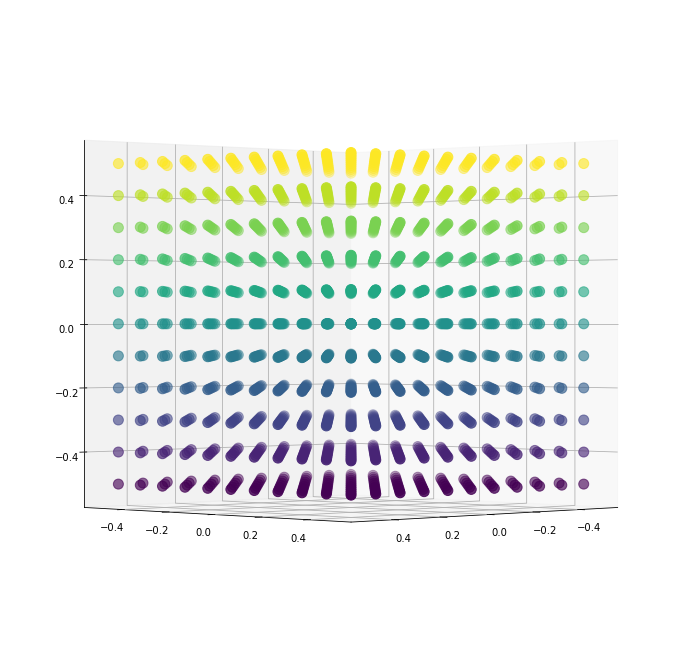

In [20]:
fig2 = plt.figure(
    figsize = (12, 12),
    facecolor = "white",
    edgecolor = "black",
)
ax3 = fig2.add_subplot(111, projection='3d')
ax3.scatter(slit_coordinate_x, slit_coordinate_y, slit_coordinate_z, s=100, c=slit_coordinate_z)
#ax3.set_box_aspect((1, 1, 1))
ax3.view_init(elev=0, azim=45)

### スリットの座標数

In [21]:
slit_count = len(slit_coordinate_x)

In [22]:
slit_count

1331

### 各スリットからスクリーン上の点までの距離の計算

$$
R = \sqrt{(L-z)^2+(X-x)^2+(Y-y)^2}
$$

In [23]:
R_points = np.array([np.sqrt(
    (L-slit_coordinate_z[i]**2)**2+(X-slit_coordinate_x[i])**2 + (Y-slit_coordinate_y[i])**2)
                     for i in range(slit_count)])

### 波の重ね合わせ（繰り返し処理）

In [24]:
@numba.njit
def calc_I(slit_count, m, k, R_points, I_points):
    for s in range(m):
        count = 0
        for t in range(m):
            # 電場の初期化
            E = 0
            for u in range(slit_count):
                # 電場の計算
                E += np.exp(1j*k*R_points[u, s, t])
            # 光強度の計算結果を格納
            I_points[s, count] = np.abs(E)**2
            count += 1

In [25]:
calc_I(slit_count, m, k, R_points, I_points)

### 光の強度分布，干渉縞のグラフ化

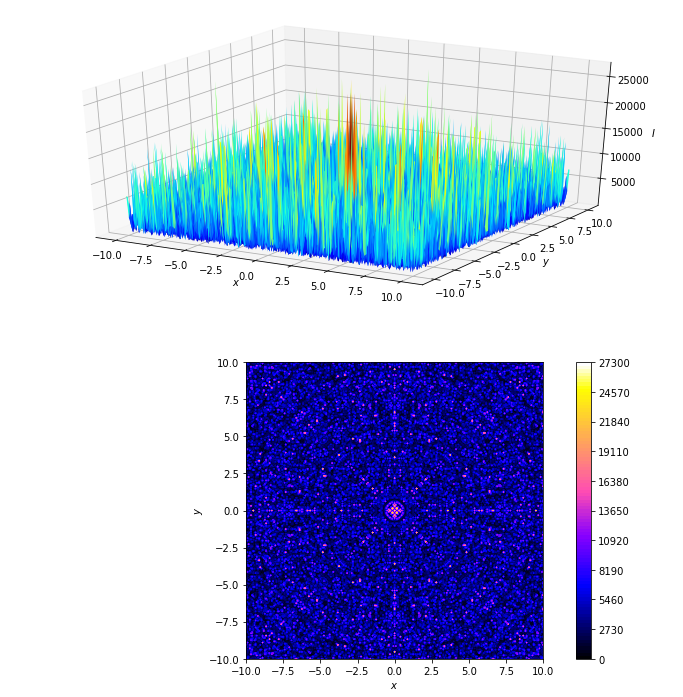

In [26]:
# https://learntutorials.net/ja/matplotlib/topic/3385/%E3%82%AB%E3%83%A9%E3%83%BC%E3%83%9E%E3%83%83%E3%83%97
fig = plt.figure(
    figsize = (12, 12),
    facecolor = "white",
    edgecolor = "black",
)

ax1 = fig.add_subplot(211, projection='3d')
ax1.plot_surface(X, Y, I_points, rstride=1, cstride=1, cmap='jet')

ax2 = fig.add_subplot(212)
# ３次元の等高線を書く
# https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
# http://taustation.com/matplotlib-pyplot-contour-contourf/#i-3
cf = ax2.contourf(X, Y, I_points, 101, vmin=I_points.min(), vmax=I_points.max(), cmap='gnuplot2')
cbar = fig.colorbar(cf)
# 
cbar.locator = LinearLocator(numticks = 11)
cbar.update_ticks()

for ax in {ax1, ax2}:
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')

ax1.set_zlabel(r'$I$')
ax2.set_aspect('equal')

In [27]:
# グラフの保存
import datetime
import pytz
time = datetime.datetime.now(pytz.timezone('Asia/Tokyo'))
#(年、月、日付、時、分、秒、マイクロ秒)

#見やすい形に変換
time = time.strftime('%m%d_3D_varsion1.png')
# 図の保存
fig.savefig(time, facecolor = fig.get_facecolor())